## Importing libraries

In [1]:
import msgpack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

from collections import OrderedDict

from geexhp.pypsg import PSG
from geexhp import datamod, datavis, stages
datavis.configure_matplotlib(oldschool=False)

2024-11-04 15:02:53.168975: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 15:02:53.169960: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 15:02:53.172577: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 15:02:53.180276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 15:02:53.193073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Test 1 - Loading HWO configuration file for Modern Earth

In [2]:
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

In [3]:
molecules = config["ATMOSPHERE-LAYERS-MOLECULES"].split(',')
pressures = []
temperatures = []
concentration_dict = {mol: [] for mol in molecules}

for i in range(60):
    layer = config.get(f"ATMOSPHERE-LAYER-{i + 1}").split(',')
    pressure = float(layer[0])
    temperature = float(layer[1])
    concentrations = [float(value) for value in layer[2:]]
    
    pressures.append(pressure)
    temperatures.append(temperature)
    for j, mol in enumerate(molecules):
        concentration_dict[mol].append(concentrations[j])

data = {
    "Pressure": pressures,
    "Temperature": temperatures
}
data.update(concentration_dict)
mixing_ratio = pd.DataFrame(data)

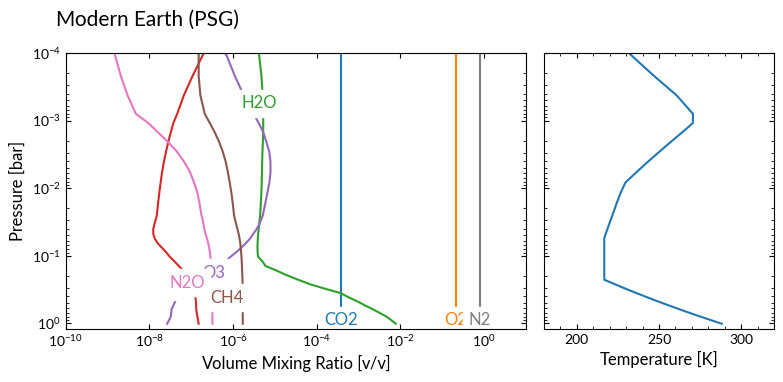

In [4]:
molecules = ["CO2", "O2", "H2O", "CO", "O3", "CH4", "N2O", "N2"]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1.5]}, sharey=True)
for molecule in molecules:
    line, = ax[0].plot(mixing_ratio[molecule], mixing_ratio["Pressure"], label=molecule)
    x_pos = np.median(line.get_xdata())
    datavis.label_line(line, x=x_pos, label=molecule, align=False)
    
ax[0].invert_yaxis()
ax[0].axis([1e-10, 10, 1.2, 1e-4])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set(xlabel="Volume Mixing Ratio [v/v]", ylabel="Pressure [bar]")

mixing_ratio.plot(x="Temperature", y="Pressure", ax=ax[1], legend=False)
ax[1].invert_yaxis()
ax[1].axis([180, 320, 1.2, 1e-4])
ax[1].set(xlabel="Temperature [K]", ylabel="")
ax[1].set_yscale("log")

fig.suptitle("Modern Earth (PSG)", x=0.08, y=0.95, horizontalalignment='left', 
                verticalalignment='top', fontsize=15)
plt.tight_layout();

In [5]:
psg = PSG(server_url= "http://127.0.0.1:3000/api.php", timeout_seconds = 200)

Testing connection to PSG at http://127.0.0.1:3000/api.php ...
Connected to PSG with success.


In [6]:
config_HWC = config.copy()
stages.modern(config_HWC)
datamod.set_instrument(config_HWC, 'HWC')
result = psg.run(config_HWC)

In [7]:
print(result["header"])

# ------------------------------------------------------------------------
# Radiance spectrum
# NASA-GSFC Planetary Spectrum Generator (PSG) (Villanueva et al. 2018, 2022)
# Synthesized on Mon Nov  4 18:03:14 2024
# Doppler velocities [km/s] (vobs,vrot+vorb,vwidth,vrfl,vstr): 0.00000,0.00000,0.00000,0.00000,-0.00000
# ------------------------------------------------------------------------
# Spectra synthesized with the Planetary and Universal Model of Atmospheric Scattering (PUMAS, Villanueva et al. 2018, 2022)
# Multiple scattering method employing PSGDORT, NMAX:1 / LMAX:2 / gMAX:0.00
# Radiative transfer took 5.110 seconds
# ------------------------------------------------------------------------
# Spectral unit: Wavelength [um]
# Radiance unit: I/F [apparent albedo]
# Wave/freq Total Noise Exoplanet


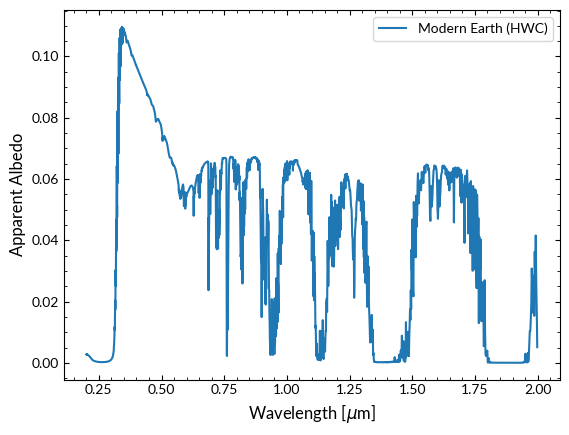

In [9]:
columns = ["WAVELENGTH_HWC", "ALBEDO_HWC"]
df_earth = pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)
datavis.plot_spectrum(df_earth, label="Modern Earth", instruments="HWC");

In [10]:
def test_instrument(config, instrument):
    datamod.set_instrument(config, instrument)
    result = psg.run(config)
    columns = [f"WAVELENGTH_{instrument}", f"ALBEDO_{instrument}"]
    return pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)

In [11]:
instruments = ["SS-UV", "SS-Vis", "SS-NIR"]
dfs = [test_instrument(config.copy(), instrument) for instrument in instruments]
df = pd.concat(dfs).reset_index(drop=True)

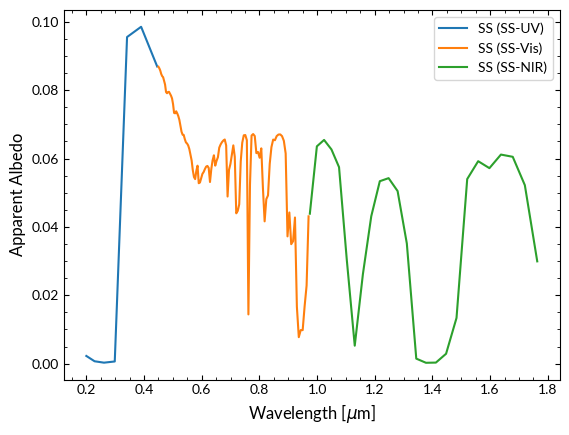

In [13]:
datavis.plot_spectrum(df, label="SS", instruments=instruments);

## Test 2 - Changing the abundances

In [17]:
def test_abundances(dictionary: dict, gas: str, multiplier: float) -> None:
    elements = ["CO2", "O2", "H2O", "CO", "O3", "CH4", "N2O", "N2"]
    gas_index = elements.index(gas)
    for key, value in dictionary.items():
        if key.startswith("ATMOSPHERE-LAYER-"):
            values = value.split(',')
            gas_value = float(values[gas_index + 2])
            new_value = gas_value * multiplier       
            values[gas_index + 2] = str(new_value)
            dictionary[key] = ','.join(values)
    result = psg.run(dictionary)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)

In [18]:
o2_modifications = [("O2", 2), ("O2", 0)]
df_double_O2, df_no_O2 = [test_abundances(config_HWC.copy(), gas, factor) for gas, factor in o2_modifications]

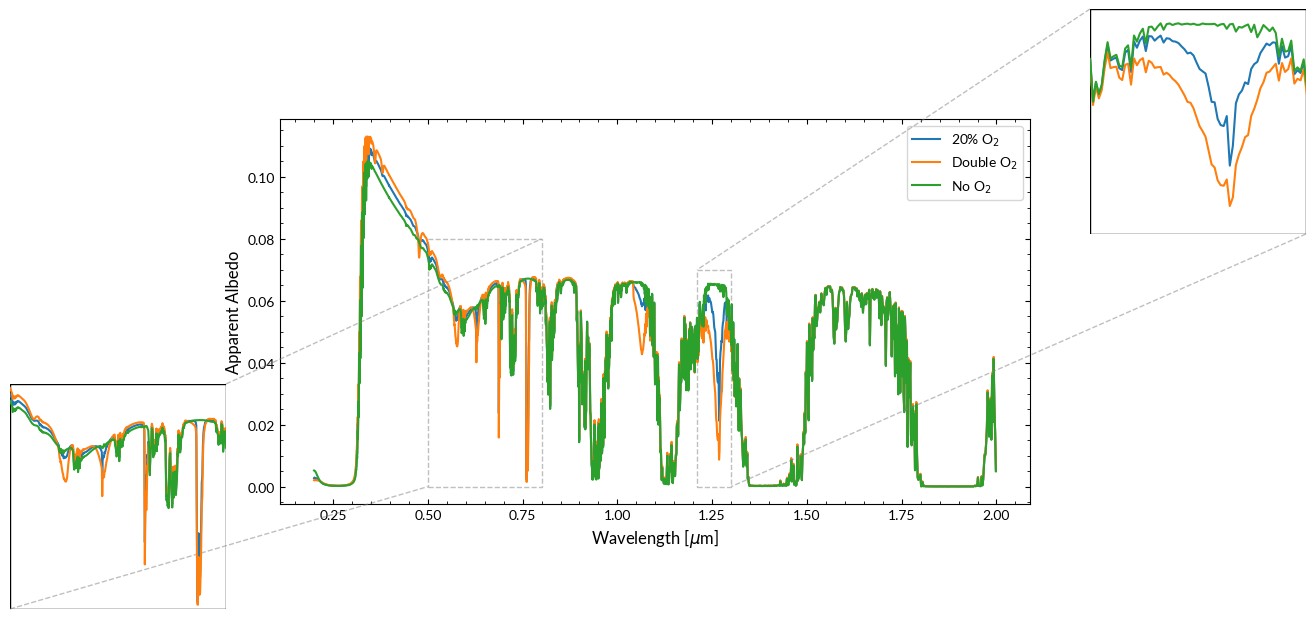

In [22]:
fig, ax_main = plt.subplots(figsize=(12, 5))

ax_main.plot(df_earth["WAVELENGTH_HWC"], df_earth["ALBEDO_HWC"], label="20% O${}_2$")
ax_main.plot(df_double_O2["WAVELENGTH"], df_double_O2["ALBEDO"], label="Double O${}_2$")
ax_main.plot(df_no_O2["WAVELENGTH"], df_no_O2["ALBEDO"], label="No O${}_2$")
ax_main.set(xlabel="Wavelength [$\mu$m]", ylabel="Apparent Albedo")
ax_main.legend()

fig.subplots_adjust(right=0.75)

ax_zoom1 = fig.add_axes([0.8, 0.65, 0.18, 0.45])
ax_zoom1.plot(df_earth["WAVELENGTH_HWC"], df_earth["ALBEDO_HWC"])
ax_zoom1.plot(df_double_O2["WAVELENGTH"], df_double_O2["ALBEDO"])
ax_zoom1.plot(df_no_O2["WAVELENGTH"], df_no_O2["ALBEDO"])
ax_zoom1.set_xlim(1.21, 1.3)
ax_zoom1.set_ylim(0.0, 0.07)
ax_zoom1.axis('off')
rect1 = Rectangle((0, 0), 1, 1, transform=ax_zoom1.transAxes, linewidth=1, edgecolor='black', facecolor='none')
ax_zoom1.add_patch(rect1)

ax_zoom2 = fig.add_axes([-0.1, -0.1, 0.18, 0.45])
ax_zoom2.plot(df_earth["WAVELENGTH_HWC"], df_earth["ALBEDO_HWC"])
ax_zoom2.plot(df_double_O2["WAVELENGTH"], df_double_O2["ALBEDO"])
ax_zoom2.plot(df_no_O2["WAVELENGTH"], df_no_O2["ALBEDO"])
ax_zoom2.set_xlim(0.5, 0.8)
ax_zoom2.set_ylim(0, 0.08)
ax_zoom2.axis('off')
rect2 = Rectangle((0, 0), 1, 1, transform=ax_zoom2.transAxes, linewidth=1, edgecolor='black', facecolor='none')
ax_zoom2.add_patch(rect2)

mark_inset(ax_main, ax_zoom1, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--', alpha=0.5)
mark_inset(ax_main, ax_zoom2, loc1=1, loc2=3, fc="none", ec="0.5", linestyle='--', alpha=0.5);

## Test 3 - Modifying atmospheric pressure (mbar)

In [23]:
def test_pressure(config, pressure):
    config["ATMOSPHERE-PRESSURE"] = str(pressure)
    result = psg.run(config)
    columns = ["WAVELENGTH_HWC", "ALBEDO_HWC"]
    return pd.DataFrame(result["spectrum"][:, [0, 1]], columns=columns)

In [24]:
# 500 mbar = .5 bar
# The spectrum returned nothing for double and 4x the atmospheric pressure
pressures = [500, 1000, 1500]
df_half_atm, df_1_0_atm, df_1_5_atm = [test_pressure(config_HWC.copy(), pressure) for pressure in pressures]

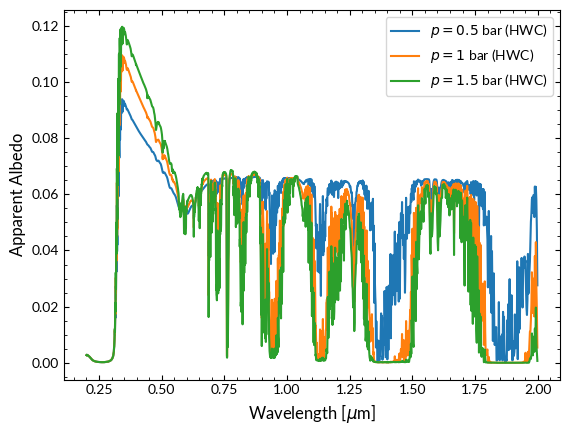

In [27]:
_, ax = plt.subplots()
datavis.plot_spectrum(df_half_atm, label="$p = 0.5$ bar", ax=ax, instruments="HWC")
datavis.plot_spectrum(df_1_0_atm, label="$p = 1$ bar", ax=ax, color="tab:orange", instruments="HWC")
datavis.plot_spectrum(df_1_5_atm, label="$p = 1.5$ bar", ax=ax, color="tab:green", instruments="HWC");

When atmospheric pressure decreases, it generally indicates a more rarefied atmosphere. On the other hand, higher atmospheric pressure suggests a denser and more expansive atmosphere. The correlation between atmospheric density and the visibility of spectral signatures is intrinsically linked to photon-molecule interaction. In a dense atmosphere, the molecules present have more opportunities to interact with photons, resulting in more pronounced spectral signatures. However, when the atmosphere is more rarefied, these interactions decrease, leading to significant attenuation of spectral signatures.

# Extra: How are other parameters influencing the spectrum?

In [28]:
# SPECTRAL TYPE

def test_spectraltype(config, class_star):
    config['OBJECT-STAR-TYPE'] = class_star
    config['GEOMETRY-STELLAR-TYPE'] = class_star
    params = {
        'F': {'temp_range': (6000, 7220), 'radius_range': (1.18, 1.79), 'mag_range': (2.50, 4.22)},
        'G': {'temp_range': (5340, 5920), 'radius_range': (0.876, 1.12), 'mag_range': (4.40, 5.34)},
        'K': {'temp_range': (3940, 5280), 'radius_range': (0.552, 0.817), 'mag_range': (5.54, 7.59)},
        'M': {'temp_range': (2320, 3870), 'radius_range': (0.104, 0.559), 'mag_range': (7.75,  13.62)}
    }

    star_temperature = round(np.random.uniform(*params[class_star]['temp_range']), 3)
    star_radius = round(np.random.uniform(*params[class_star]['radius_range']), 3)
    star_mag = round(np.random.uniform(*params[class_star]['mag_range']), 3)

    config['OBJECT-STAR-RADIUS'] = star_radius
    config['OBJECT-STAR-TEMPERATURE'] = star_temperature
    config['GEOMETRY-STELLAR-TEMPERATURE'] = star_temperature
    config["GEOMETRY-STELLAR-MAGNITUDE"] = star_mag
    config["GEOMETRY-OBS-ALTITUDE"] = 3
    
    result = psg.run(config)
    noisy_albedo = np.random.normal(
            loc=result["spectrum"][:, 1],  
            scale=result["spectrum"][:, 2])
    df = pd.DataFrame({
        "WAVELENGTH_HWC": result["spectrum"][:, 0],
        "ALBEDO_HWC": result["spectrum"][:, 1],
        "NOISE_HWC": result["spectrum"][:, 2],
        "NOISY_ALBEDO_HWC": noisy_albedo})
    return df

In [29]:
sts = ['F', 'G', 'K', 'M']
F, G, K, M = [test_spectraltype(config_HWC.copy(), st) for st in sts]

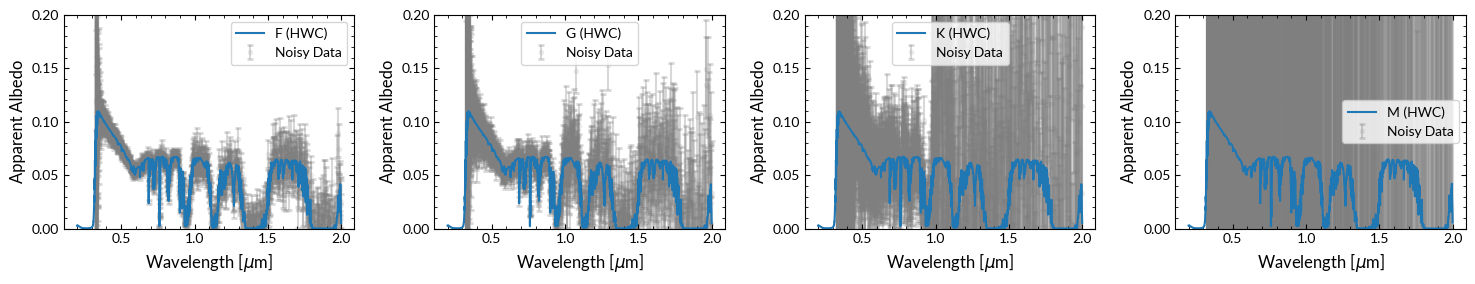

In [39]:
_, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(15,3))

datavis.plot_spectrum(F, label="F", noise=True, ax=ax1, instruments="HWC")
datavis.plot_spectrum(G, label="G", noise=True, ax=ax2, instruments="HWC")
datavis.plot_spectrum(K, label="K", noise=True, ax=ax3, instruments="HWC")
datavis.plot_spectrum(M, label="M", noise=True, ax=ax4, instruments="HWC")

for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylim(0, 0.2)

plt.tight_layout();

In [40]:
## GRAVITY AND PLANET RADIUS

# Just this cell
import astropy.units as u
from astropy.constants import G, M_earth, R_earth

def test_radiusgrav(config, planet_radius, planet_mass):
    gravity = G.value * (planet_mass * M_earth.value) / (planet_radius * R_earth.value) ** 2
    config['OBJECT-DIAMETER'] = 2 * planet_radius * R_earth.to(u.km).value
    config['OBJECT-GRAVITY'] = gravity
    
    result = psg.run(config)
    noise = result["spectrum"][:, 2]
    finite_noise = noise[np.isfinite(noise)]
    if finite_noise.size > 0:
        max_finite_noise = np.max(finite_noise)
    else:
        max_finite_noise = 0
    
    noise[np.isinf(noise)] = max_finite_noise
    noisy_albedo = np.random.normal(
        loc=result["spectrum"][:, 1],  
        scale=noise)
    df = pd.DataFrame({
        "WAVELENGTH_WHC": result["spectrum"][:, 0],
        "ALBEDO_WHC": result["spectrum"][:, 1],
        "NOISE_WHC": noise,
        "NOISY_ALBEDO_WHC": noisy_albedo})
    return df

In [41]:
planet_radii = [1, 1, 1]
planet_masses = [0.5, 2, 10]
p05, p15, p2 = [test_radiusgrav(config_HWC.copy(), radius, mass) for radius, mass in zip(planet_radii, planet_masses)]

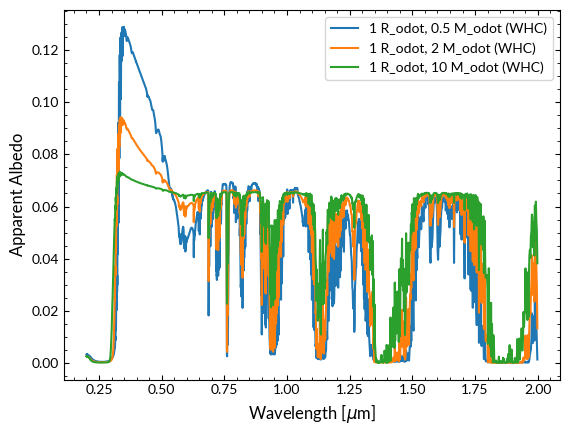

In [42]:
_, ax = plt.subplots()
datavis.plot_spectrum(p05, label="1 R_odot, 0.5 M_odot", ax=ax, instruments="WHC")
datavis.plot_spectrum(p15, label="1 R_odot, 2 M_odot", ax=ax, instruments="WHC", color="tab:orange")
datavis.plot_spectrum(p2, label="1 R_odot, 10 M_odot", ax=ax, instruments="WHC", color="tab:green");

In [43]:
planet_radii = [0.5, 2, 10]
planet_masses = [1, 1, 1]
p05, p15, p2 = [test_radiusgrav(config_HWC.copy(), radius, mass) for radius, mass in zip(planet_radii, planet_masses)]

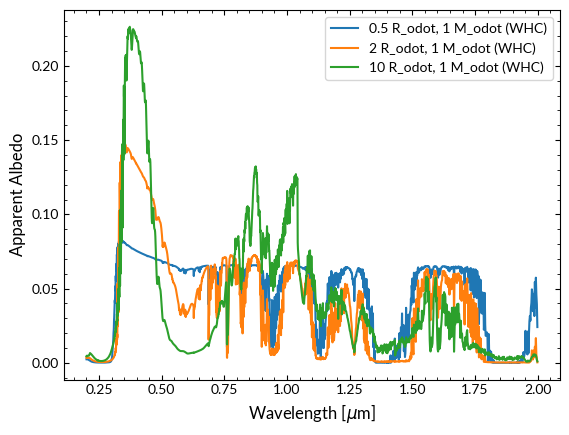

In [44]:
_, ax = plt.subplots()
datavis.plot_spectrum(p05, label="0.5 R_odot, 1 M_odot", ax=ax, instruments="WHC")
datavis.plot_spectrum(p15, label="2 R_odot, 1 M_odot", ax=ax, instruments="WHC", color="tab:orange")
datavis.plot_spectrum(p2, label="10 R_odot, 1 M_odot", ax=ax, instruments="WHC", color="tab:green");

## 2.0Ga after the Great Oxidation Event (Proterozoic)

In [45]:
def justdoit(config, event, instrument):
    config_copy = config.copy()
    event(config_copy)
    datamod.set_instrument(config_copy, instrument)
    result = psg.run(config_copy)
    columns = ["WAVELENGTH_HWC", "ALBEDO_HWC"]
    return pd.DataFrame(result["spectrum"][:, [0, 1]], columns=columns)

In [46]:
proterozoic = justdoit(config, stages.proterozoic, "HWC")

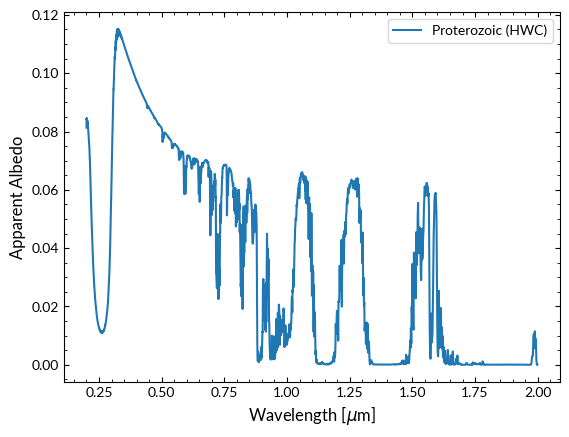

In [49]:
_, ax = plt.subplots()
datavis.plot_spectrum(proterozoic, label="Proterozoic", ax=ax, instruments="HWC");
#datavis.plot_spectrum(df_earth, label="Modern Earth", ax=ax);

## Archean Earth

In [50]:
archean = justdoit(config, stages.archean, "HWC")

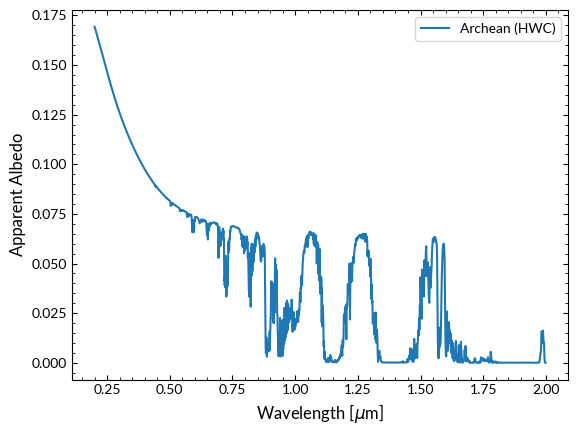

In [51]:
_, ax = plt.subplots()
datavis.plot_spectrum(archean, label="Archean", ax=ax, instruments="HWC");
# datavis.plot_spectrum(proterozoic, label="Proterozoic", ax=ax)
# datavis.plot_spectrum(df_earth, label="Modern Earth", ax=ax);

## Generate a random modern earth

In [55]:
random_config = config_HWC.copy()
datamod.random_planet(random_config, stages.molweightlist("modern"))
result_random = psg.run(random_config)

columns = ["WAVELENGTH_HWC", "ALBEDO_HWC"]
df_rnd = pd.DataFrame(result_random["spectrum"][:, [0,1]], columns=columns)

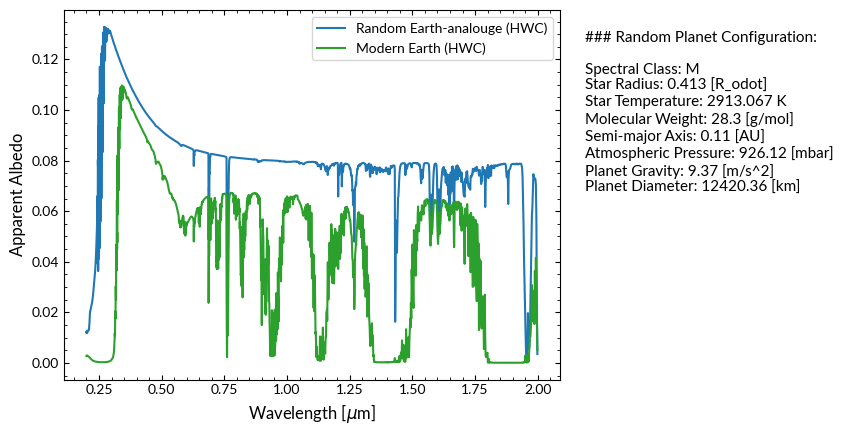

In [56]:
SPECTRAL_CLASS = random_config['OBJECT-STAR-TYPE']
STAR_RADIUS = random_config['OBJECT-STAR-RADIUS']
STAR_TEMPERATURE = random_config['OBJECT-STAR-TEMPERATURE']
MOLECULAR_WEIGHT = round(random_config['ATMOSPHERE-WEIGHT'], 2)
SEMI_MAJOR_AXIS = round(random_config['OBJECT-STAR-DISTANCE'], 2)
ATMOSPHERIC_PRESSURE = round(random_config["ATMOSPHERE-PRESSURE"], 2)
PLANET_GRAVITY = round(random_config['OBJECT-GRAVITY'], 2)
PLANET_DIAMETER = round(random_config['OBJECT-DIAMETER'], 2)

_, ax = plt.subplots()
datavis.plot_spectrum(df_rnd, label="Random Earth-analouge", ax = ax, instruments="HWC")
datavis.plot_spectrum(df_earth, label="Modern Earth", ax = ax, instruments="HWC", color="tab:green")
ax.legend()

text = ("### Random Planet Configuration:\n\n"
        f"Spectral Class: {SPECTRAL_CLASS}\n"
        f"Star Radius: {STAR_RADIUS} [R_odot]\n"
        f"Star Temperature: {STAR_TEMPERATURE} K\n"
        f"Molecular Weight: {MOLECULAR_WEIGHT} [g/mol]\n"
        f"Semi-major Axis: {SEMI_MAJOR_AXIS} [AU]\n"
        f"Atmospheric Pressure: {ATMOSPHERIC_PRESSURE} [mbar]\n"
        f"Planet Gravity: {PLANET_GRAVITY} [m/s^2]\n"       
        f"Planet Diameter: {PLANET_DIAMETER} [km]\n"
        )

plt.text(1.05, 0.7, text,
        horizontalalignment='left',
        verticalalignment='center',
        fontsize = 11, transform=plt.gca().transAxes);